<h1 style="color:green; margin-bottom:15px;font-size:32px">Ticketing Website Marketing Data Analysis</h1>

# Data

The dataset contains 3 files exported by the marketing department of Yandex Afisha (Russian ticketing website) from June 2017 till May 2018:<br>
<ol>
<li>visits_log.csv - server log with website visits,</li>
<li>orders_log.csv - all orders,</li>
<li>costs.csv - advertising costs statistics.</li>
</ol>

# Project Goal

The goal of the project is to help the marketing department to reduce costs by eliminating unprofitable traffic sources and reallocating the marketing budget.

In this project we'll answer the following questions:
<ol>
<li>how customers use the website</li>
<li>when they make their first purchases</li>
<li>how much money each client brings</li>
<li>when the cost of customer acquisition pays off</li>
</ol>

# Contents

<ol>
<li>Libraries Import</li>
<li>Data Import and Preprocessing</li>
<li>Data Description</li>
<li>Metrics Calculation</li>
     - Product Metrics<br>
     - Ecommerce Metrics<br>
     - Marketing Metrics<br>
<li>Conclusion and Recommendations</li>
</ol>

# 1. Libraries Import

In [1]:
import pandas as pd
import math
import numpy as np
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data Import and Preprocessing

# 2.1. Visits Table

<ul>
<li>Let's convert variable names to lowercase with an underscore instead of a space</li>
<li>Convert data types when need</li>
<li>Process outliers, gaps and duplicates</li>
<li>Let's add additional variables month, week, date, we will need them later</li>
</ul>

In [2]:
visits=pd.read_csv('visits_log.csv')

display(visits.head(5))
display(visits.info())

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

In [3]:
visits.columns = visits.columns.str.lower()
visits = visits.rename({'start ts': 'start_ts', 'source id': 'source_id', 'end ts': 'end_ts'}, axis='columns')

In [4]:
duplicates = visits[visits.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [device, end_ts, source_id, start_ts, uid]
Index: []


In [5]:
visits['end_ts'] = visits['end_ts'].astype('datetime64')
visits['start_ts'] = visits['start_ts'].astype('datetime64')

In [6]:
print(visits['device'].value_counts().count())
print(visits['device'].value_counts())

print(visits['source_id'].value_counts().count())
print(visits['source_id'].value_counts())

2
desktop    262567
touch       96833
Name: device, dtype: int64
9
4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64


In [7]:
print(visits['start_ts'].describe())
print()
print(visits['end_ts'].describe())

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

count                  359400
unique                 224760
top       2017-11-24 16:51:00
freq                       23
first     2017-06-01 00:02:00
last      2018-06-01 01:26:00
Name: end_ts, dtype: object


In [8]:
visits['month'] = visits['start_ts'].astype('datetime64[M]')
visits['week'] = visits['start_ts'].astype('datetime64[W]')
visits['date'] = visits['start_ts'].astype('datetime64[D]')

Let's convert source_id into string, numeric type will not work as a legend for sns.lineplot (that will be built later)

In [9]:
visits.loc[(visits['source_id'] == 1), 'source'] = 'source1'
visits.loc[(visits['source_id'] == 2), 'source'] = 'source2'
visits.loc[(visits['source_id'] == 3), 'source'] = 'source3'
visits.loc[(visits['source_id'] == 4), 'source'] = 'source4'
visits.loc[(visits['source_id'] == 5), 'source'] = 'source5'
visits.loc[(visits['source_id'] == 9), 'source'] = 'source9'
visits.loc[(visits['source_id'] == 10), 'source'] = 'source10'
visits.drop(['source_id'], axis=1, inplace=True)

In [10]:
display(visits.head(5))
display(visits.info())

,device,end_ts,start_ts,uid,month,week,date,source
0,touch,2017-12-20 17:38:00,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20,source4
1,desktop,2018-02-19 17:21:00,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19,source2
2,touch,2017-07-01 01:54:00,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,source5
3,desktop,2018-05-20 11:23:00,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20,source9
4,desktop,2017-12-27 14:06:00,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-21,2017-12-27,source3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   device    359400 non-null  object        
 1   end_ts    359400 non-null  datetime64[ns]
 2   start_ts  359400 non-null  datetime64[ns]
 3   uid       359400 non-null  uint64        
 4   month     359400 non-null  datetime64[ns]
 5   week      359400 non-null  datetime64[ns]
 6   date      359400 non-null  datetime64[ns]
 7   source    359358 non-null  object        
dtypes: datetime64[ns](5), object(2), uint64(1)
memory usage: 21.9+ MB


None

Source variable contains 42 gaps (0.01%), we will remove these gaps at a later stage

# 2.2 Orders Table

In [11]:
orders=pd.read_csv('orders_log.csv')
display(orders.head(5))
display(orders.info())
display(orders.describe())

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


In [12]:
orders.columns = orders.columns.str.lower()
orders = orders.rename({'buy ts': 'buy_ts'}, axis='columns')

In [13]:
duplicates = orders[orders.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [buy_ts, revenue, uid]
Index: []


In [14]:
orders.loc[orders['revenue'] == 0].count()

buy_ts     51
revenue    51
uid        51
dtype: int64

There are 51 orders with 0 revenue, this can be explained by either a technical error on the payment processor side or by a purchase with a gift card 

In [15]:
orders.drop(orders[orders['revenue'] == 0].index, inplace=True)
orders = orders.reset_index(drop=True) 

In [16]:
orders['buy_ts'] = orders['buy_ts'].astype('datetime64')

In [17]:
orders['month'] = orders['buy_ts'].astype('datetime64[M]')
orders['week'] = orders['buy_ts'].astype('datetime64[W]')
orders['date'] = orders['buy_ts'].astype('datetime64[D]')

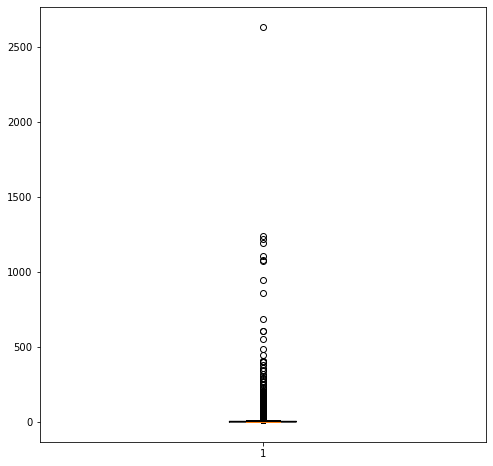

In [18]:
fig = plt.figure(figsize =(8, 8))
plt.boxplot(orders['revenue'], notch=True)
plt.show()

The revenue variable contains many abnormally high values. We won't remove them in this analysis - we can't ignore high-paying users and expensive acquisition channels when analyzing ad performance.

In [19]:
print(orders['buy_ts'].describe())

count                   50364
unique                  45950
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object


In [20]:
display(orders.head(5))
display(orders.info())

,buy_ts,revenue,uid,month,week,date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50364 entries, 0 to 50363
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50364 non-null  datetime64[ns]
 1   revenue  50364 non-null  float64       
 2   uid      50364 non-null  uint64        
 3   month    50364 non-null  datetime64[ns]
 4   week     50364 non-null  datetime64[ns]
 5   date     50364 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), uint64(1)
memory usage: 2.3 MB


None

# 1.3. Costs Table

In [21]:
costs=pd.read_csv('costs.csv')
display(costs.head(5))
display(costs.info())
display(costs.describe())

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


In [22]:
costs.columns = costs.columns.str.lower()
costs = costs.rename({'dt': 'date'}, axis='columns')

In [23]:
duplicates = costs[costs.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [source_id, date, costs]
Index: []


In [24]:
costs.loc[costs['costs'] == 0].count()

source_id    0
date         0
costs        0
dtype: int64

In [25]:
costs['date'] = costs['date'].astype('datetime64')

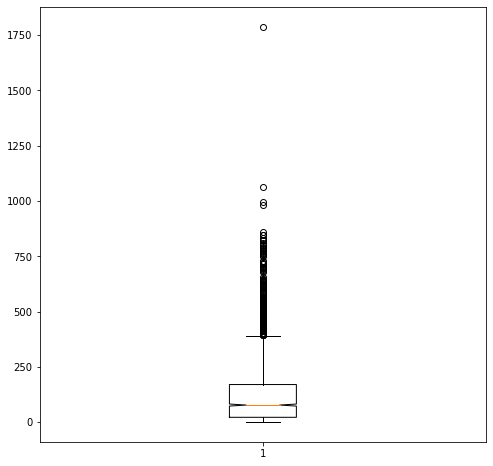

In [26]:
fig = plt.figure(figsize =(8, 8))
plt.boxplot(costs['costs'], notch=True)
plt.show()

The costs variable  contains many abnormally high values. We won't remove them in this analysis - we can't ignore high-paying users and expensive acquisition channels when analyzing ad performance.

In [27]:
print(costs['date'].describe())

count                    2542
unique                    364
top       2017-06-28 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: date, dtype: object


In [28]:
costs['month'] = costs['date'].astype('datetime64[M]')
costs['week'] = costs['date'].astype('datetime64[W]')
costs['date'] = costs['date'].astype('datetime64[D]')

In [29]:
print(costs['source_id'].value_counts())
costs['source'] = costs['source_id']

5     364
2     363
4     363
10    363
1     363
3     363
9     363
Name: source_id, dtype: int64


Let's convert source into string, numeric type will not work as a legend for sns.lineplot (that will be built later)

In [30]:
costs.loc[(costs['source_id'] == 1), 'source'] = 'source1'
costs.loc[(costs['source_id'] == 2), 'source'] = 'source2'
costs.loc[(costs['source_id'] == 3), 'source'] = 'source3'
costs.loc[(costs['source_id'] == 4), 'source'] = 'source4'
costs.loc[(costs['source_id'] == 5), 'source'] = 'source5'
costs.loc[(costs['source_id'] == 9), 'source'] = 'source9'
costs.loc[(costs['source_id'] == 10), 'source'] = 'source10'
costs.drop(['source_id'], axis=1, inplace=True)

In [31]:
display(costs.head(5))
display(costs.info())

,date,costs,month,week,source
0,2017-06-01,75.20,2017-06-01,2017-06-01,source1
1,2017-06-02,62.25,2017-06-01,2017-06-01,source1
2,2017-06-03,36.53,2017-06-01,2017-06-01,source1
3,2017-06-04,55.00,2017-06-01,2017-06-01,source1
4,2017-06-05,57.08,2017-06-01,2017-06-01,source1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2542 non-null   datetime64[ns]
 1   costs   2542 non-null   float64       
 2   month   2542 non-null   datetime64[ns]
 3   week    2542 non-null   datetime64[ns]
 4   source  2542 non-null   object        
dtypes: datetime64[ns](3), float64(1), object(1)
memory usage: 99.4+ KB


None

# 3. Data Description after Preprocessing

<ol>
<li>visits_log.csv - server log with website visits,</li>
<li>orders_log.csv - info on all orders,</li>
<li>costs.csv - advertising costs statistics.</li>
</ol>

**df visits has 359400 rows and 8 variables**
<ol>
<li>uid — unique user identifier, type uint64</li>
<li>device — user device category, type object</li>
<li>start_ts — session start date and time, type datetime64</li>
<li>month — session start month, type datetime64</li>
<li>week — session start week, type datetime64</li>
<li>date — session start date, type datetime64</li>
<li>end_ts — session end date and time, type datetime64</li>
<li>source — source of the visit, type object</li>
</ol>

**df orders has 50364 rows and 6 variables**
<ol>
<li>uid — unique user identifier, type uint64</li>
<li>buy_ts — order date and time, type datetime64</li>
<li>month — order month, type datetime64</li>
<li>week — order week, type datetime64</li>
<li>date — order date, type datetime64</li>
<li>revenue — earning by orders, type int64.</li>
</ol>

**df costs has 2542 rows and 6 variables**
<ol>
<li>source — advertising source identifier, type object</li>
<li>date — date of the advertising campaign, type datetime64</li>
<li>month — month of the advertising campaign, type datetime64</li>
<li>week — week of the advertising campaign, type datetime64</li>
<li>date — date of the advertising campaign, type datetime64</li>
<li>costs — campaigns costs, type float64.</li>
</ol>

The source variable contains 42 gaps (0.01%), we will remove the gaps at a later stage.

The data has been preprocessed. The data types have been converted when needed. Dataframes do not contain garbage and duplicates.

The variables revenue and costs contain many abnormally large values. We won't remove them in this analysis - we can't ignore high-paying users and expensive acquisition channels when analyzing ad performance.

<h1 style="color:green; margin-bottom:15px;font-size:30px">4. Metrics Calculation</h1>

# 4.1. Product Metrics

## 4.1.1. DAU (Daily Active Users), WAU (Weekly Active Users) and MAU (Monthly Active Users)

In [32]:
dau = visits.groupby('date').agg({'uid': 'nunique'})

wau = (
    visits.groupby('week')
    .agg({'uid': 'nunique'}).sort_values('uid', ascending=True)
)

mau = (
    visits.groupby('month')
    .agg({'uid': 'nunique'}).sort_values('uid', ascending=True)
)

print('DAU', int(dau.mean()))
print('WAU', int(wau.mean()))
print('MAU', int(mau.mean()))

DAU 907
WAU 5724
MAU 23228


In [33]:
dau = dau.sort_values('uid', ascending=True)
wau = wau.sort_values('uid', ascending=True)
mau = mau.sort_values('uid', ascending=True)

rows = 3

print('DAU: Top-3 and Tail-3')
print(dau.head(rows).append(dau.tail(rows)))
print()

print('WAU: Top-3 and Tail-3')
print(wau.head(rows).append(wau.tail(rows)))
print()

print('MAU: Top-3 and Tail-3')
print(mau.head(rows).append(mau.tail(rows)))

DAU: Top-3 and Tail-3
             uid
date            
2018-03-31     1
2018-03-30   131
2017-08-12   271
2017-11-25  1817
2018-05-31  1997
2017-11-24  3319

WAU: Top-3 and Tail-3
              uid
week             
2018-05-31   1997
2017-08-03   2343
2017-07-27   2505
2018-03-22   8486
2017-12-07   8575
2017-11-23  10716

MAU: Top-3 and Tail-3
              uid
month            
2017-08-01  11631
2017-06-01  13259
2017-07-01  14183
2017-10-01  29692
2017-12-01  31557
2017-11-01  32797


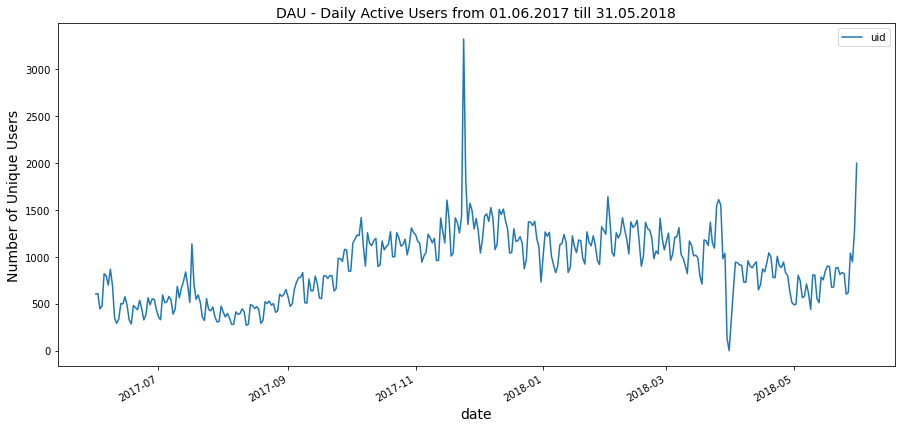

In [34]:
fig, ax = plt.subplots(figsize=(15,7))
plt.xlabel('Day',fontsize=14)
plt.ylabel('Number of Unique Users',fontsize=14)
plt.title('DAU - Daily Active Users from 01.06.2017 till 31.05.2018',fontsize=14)
dau.plot(ax=ax,legend=True)
plt.show()

## DAU

<ul>
<li>Average number of unique users per day - 907</li>
<li>DAU Maximum (3319 users) was reached on 2017-11-24, Black Friday 2017</li>
<li>DAU Minimum was reached on 2018-03-30 and 2018-03-31 (1 and 131 users), most likely due to site outages</li>
<li>DAU peaks mid-week and drops over the weekend</li>
</ul>

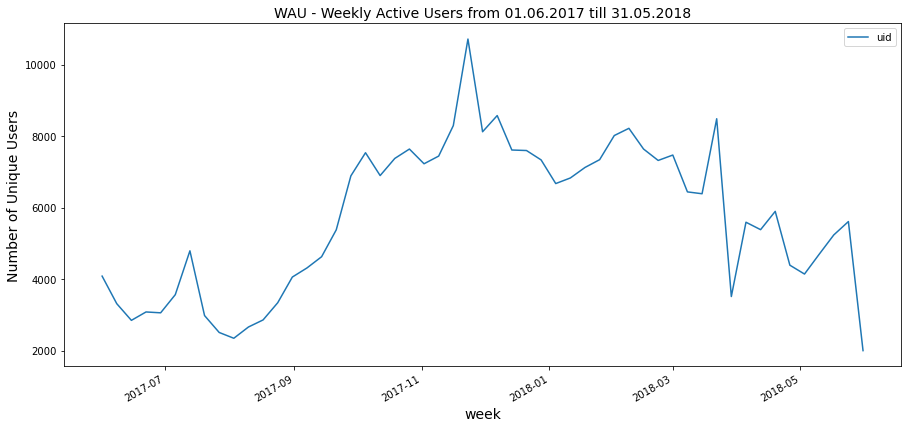

In [35]:
fig, ax = plt.subplots(figsize=(15,7))
plt.xlabel('Week',fontsize=14)
plt.ylabel('Number of Unique Users',fontsize=14)
plt.title('WAU - Weekly Active Users from 01.06.2017 till 31.05.2018',fontsize=14)
wau.plot(ax=ax,legend=True)
plt.show()

## WAU
<ul>
<li>Average number of unique users per week - 5724</li>
<li>WAU Maximum (10716 users) was reached on Black Friday 2017 week</li>
<li>WAU Minimum (1997 users) was reached on site outages week</li>
</ul>

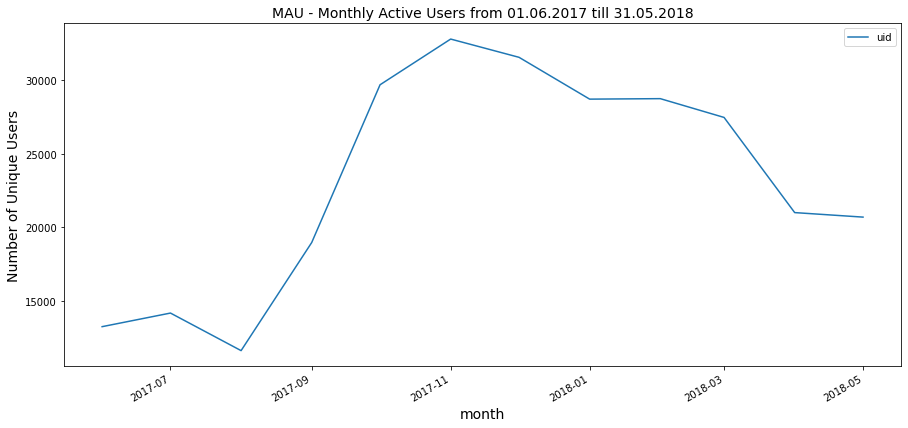

In [36]:
fig, ax = plt.subplots(figsize=(15,7))
plt.xlabel('Month',fontsize=14)
plt.ylabel('Number of Unique Users',fontsize=14)
plt.title('MAU - Monthly Active Users from 01.06.2017 till 31.05.2018',fontsize=14)
mau.plot(ax=ax,legend=True)
plt.show()

## MAU
<ul>
<li>Average number of unique users per month - 23228</li>
<li>MAU Maximum (32797 users) was reached in November 2017</li>
<li>MAU Minimum (11631 users) was reached in August 2017</li>
<li>MAU fluctuates around 10-15k users from June to August 2017, starts to grow from August 2017 (11631 users), peaks in November 2017 (32797) and goes down till the end of observations</li>
</ul>

The two-day site outage affected DAU and WAU, and Black Friday set the maximum for DAU, WAU, MAU for the entire observation period

## 4.1.2. Daily Sessions per User

In [37]:
sessions_per_user = visits.groupby(['date']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
print(sessions_per_user['sess_per_user'].mean())

1.0821696440039723


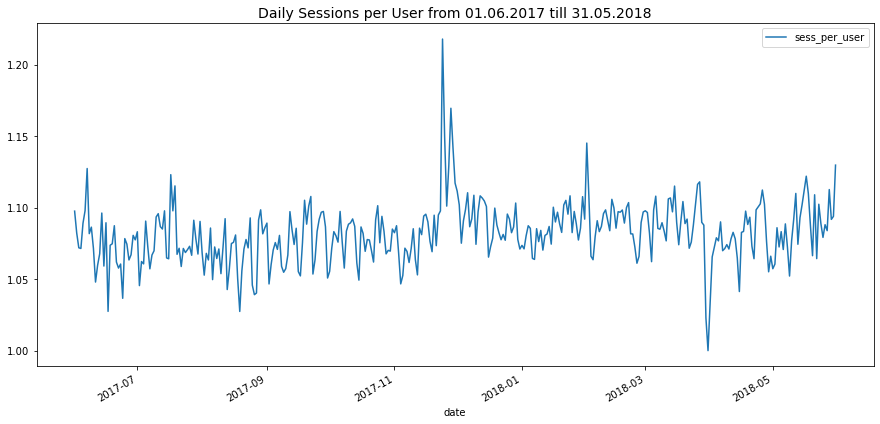

In [38]:
fig, ax = plt.subplots(figsize=(15,7))
plt.title('Daily Sessions per User from 01.06.2017 till 31.05.2018',fontsize=14)
sessions_per_user['sess_per_user'].plot(ax=ax,legend=True)
plt.show()

The average user visits the website 1.08 times a day, this number drops to 1 on the day of the failure and rises to 1.2 on Black Friday.

## 4.1.3. ASL - Average Session Duration

In [39]:
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration'] = round(visits['session_duration']/60, 0)
visits['session_duration'].describe()

count    359400.000000
mean         10.724343
std          16.939390
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max        1408.000000
Name: session_duration, dtype: float64

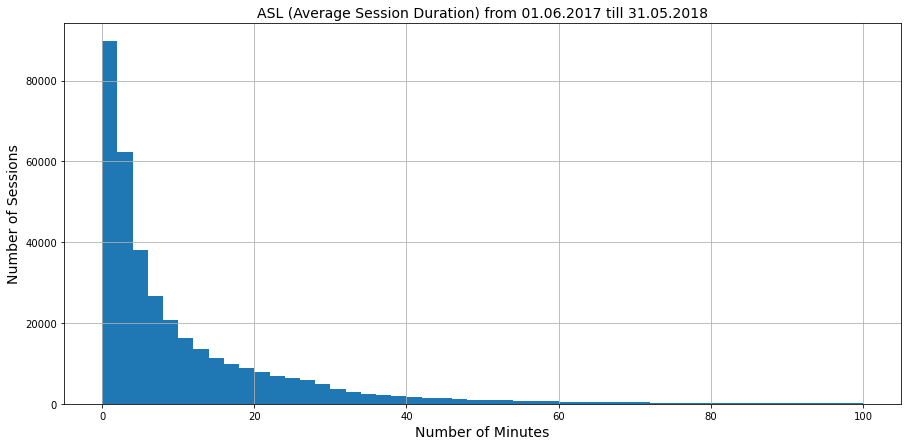

In [40]:
fig, ax = plt.subplots(figsize=(15,7))
plt.xlabel('Number of Minutes',fontsize=14)
plt.ylabel('Number of Sessions',fontsize=14)
plt.title('ASL (Average Session Duration) from 01.06.2017 till 31.05.2018',fontsize=14)
visits['session_duration'].hist(bins=50, ax=ax, range=(0, 100))
plt.show()

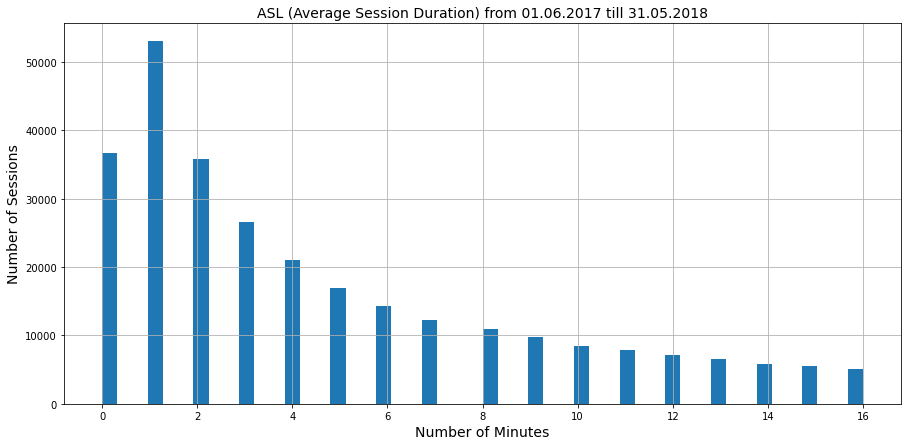

In [41]:
fig, ax = plt.subplots(figsize=(15,7))
plt.xlabel('Number of Minutes',fontsize=14)
plt.ylabel('Number of Sessions',fontsize=14)
plt.title('ASL (Average Session Duration) from 01.06.2017 till 31.05.2018',fontsize=14)
visits['session_duration'].hist(bins=50, ax=ax, range=(0, 16))
plt.show()

In [42]:
asl = visits['session_duration'].mode()[0]
print('ASL Mode:',asl)

ASL Mode: 1.0


The average session duration is 1 minute. (The distribution of ASL is similar to Pearson's distribution. When the distribution is close to normal or normal, you can look at the mean or median. Ours is not one of those, so we calculated the mode.)

50% of users spend on the website 0-5 minutes.


## 4.1.4. Cohort Analysis - Retention Rate

In [43]:
first_session_date = visits.groupby(['uid'])['date'].min().reset_index().rename(columns={'uid':'uid','date':'first_date'})
visits_retention = visits.merge(first_session_date , on='uid', how='outer')

visits_retention['first_month'] = visits_retention['first_date'].astype('datetime64[M]')
visits_retention['month'] = visits_retention['month'].astype('datetime64[M]')

visits_retention['cohort_lifetime'] = visits_retention['month'] - visits_retention['first_month']
visits_retention['cohort_lifetime'] = visits_retention['cohort_lifetime'] / np.timedelta64(1, 'M')
visits_retention['cohort_lifetime'] = visits_retention['cohort_lifetime'].round().astype('int') 

cohorts = visits_retention.groupby(['first_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_month', 'uid']]
print(initial_users_count)

   first_month    uid
0   2017-06-01  13259
12  2017-07-01  13140
23  2017-08-01  10181
33  2017-09-01  16704
42  2017-10-01  25977
50  2017-11-01  27248
57  2017-12-01  25268
63  2018-01-01  22624
68  2018-02-01  22197
72  2018-03-01  20589
75  2018-04-01  15709
77  2018-05-01  15273


In [44]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_month') 

cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

cohorts['first_month'] = pd.to_datetime(cohorts['first_month']).dt.to_period('M')

retention_pivot = cohorts.pivot_table(
    index='first_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
) 

retention_pivot = retention_pivot.iloc[: , 1:]

In [45]:
print('Average Retention Rate on the 2nd month', round(retention_pivot[1].mean(),3))

Average Retention Rate on the 2nd month 0.065


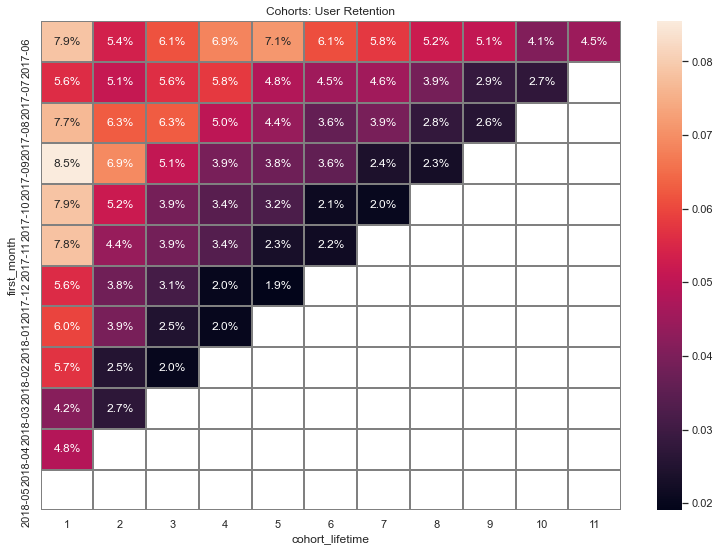

In [46]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 

The user retention rate is quite low for all cohorts and decreases every month in each cohort.

The average retention rate on the 2nd month across all cohorts is 6.5%.

The highest retention rate was reached in the first cohort - 4.5% after 11 months of follow-up.

The rest of the cohorts (except for the last one) achieve 1.9-2.7% retention by the end of the follow-up period.

# 4.2 Ecommerce Metrics

## 4.2.1. Time to Purchase

In [47]:
first_session_date_time = visits.groupby(['uid'])['start_ts'].min()
first_session_date_time.name = 'first_session_date_time'
visits = visits.join(first_session_date_time, on='uid')

first_visit = visits[['uid','first_session_date_time']].drop_duplicates()
print(first_visit)

                         uid first_session_date_time
0       16879256277535980062     2017-12-20 17:20:00
1         104060357244891740     2018-02-19 16:53:00
2        7459035603376831527     2017-07-01 01:54:00
3       16174680259334210214     2018-03-09 20:05:00
4        9969694820036681168     2017-12-27 14:06:00
...                      ...                     ...
358517  12734910664455613822     2018-04-23 21:11:00
358522   6761309174945977743     2017-11-08 13:39:00
358525  11102751930812818282     2017-07-31 12:13:00
358527    272012551460639309     2018-03-20 15:11:00
358530   3266363999948772866     2018-04-03 11:19:00

[228169 rows x 2 columns]


In [48]:
first_order_date_time = orders.groupby(['uid'])['buy_ts'].min()
first_order_date_time.name = 'first_order_date_time'
orders = orders.join(first_order_date_time, on='uid')

first_order = orders[['uid','first_order_date_time']].drop_duplicates()
print(first_order)

                        uid first_order_date_time
0      10329302124590727494   2017-06-01 00:10:00
1      11627257723692907447   2017-06-01 00:25:00
2      17903680561304213844   2017-06-01 00:27:00
3      16109239769442553005   2017-06-01 00:29:00
4      14200605875248379450   2017-06-01 07:58:00
...                     ...                   ...
50359  12296626599487328624   2018-05-31 23:50:00
50360  11369640365507475976   2018-05-31 23:50:00
50361   1786462140797698849   2018-05-31 23:54:00
50362   3993697860786194247   2018-05-31 23:56:00
50363     83872787173869366   2018-06-01 00:02:00

[36509 rows x 2 columns]


In [49]:
visit_to_order = first_order.merge(first_visit , on='uid', how='inner')
print(visit_to_order)

                        uid first_order_date_time first_session_date_time
0      10329302124590727494   2017-06-01 00:10:00     2017-06-01 00:09:00
1      11627257723692907447   2017-06-01 00:25:00     2017-06-01 00:14:00
2      17903680561304213844   2017-06-01 00:27:00     2017-06-01 00:25:00
3      16109239769442553005   2017-06-01 00:29:00     2017-06-01 00:14:00
4      14200605875248379450   2017-06-01 07:58:00     2017-06-01 07:31:00
...                     ...                   ...                     ...
36504  12296626599487328624   2018-05-31 23:50:00     2018-05-31 09:11:00
36505  11369640365507475976   2018-05-31 23:50:00     2018-05-31 23:05:00
36506   1786462140797698849   2018-05-31 23:54:00     2018-05-31 23:52:00
36507   3993697860786194247   2018-05-31 23:56:00     2017-10-23 12:32:00
36508     83872787173869366   2018-06-01 00:02:00     2018-05-31 23:59:00

[36509 rows x 3 columns]


In [50]:
visit_to_order['time_to_order'] = (visit_to_order['first_order_date_time'] - visit_to_order['first_session_date_time']).dt.seconds
visit_to_order['time_to_order'] = visit_to_order['time_to_order']/60
visit_to_order['time_to_order'].describe()

count    36509.000000
mean       249.216522
std        429.770861
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
Name: time_to_order, dtype: float64

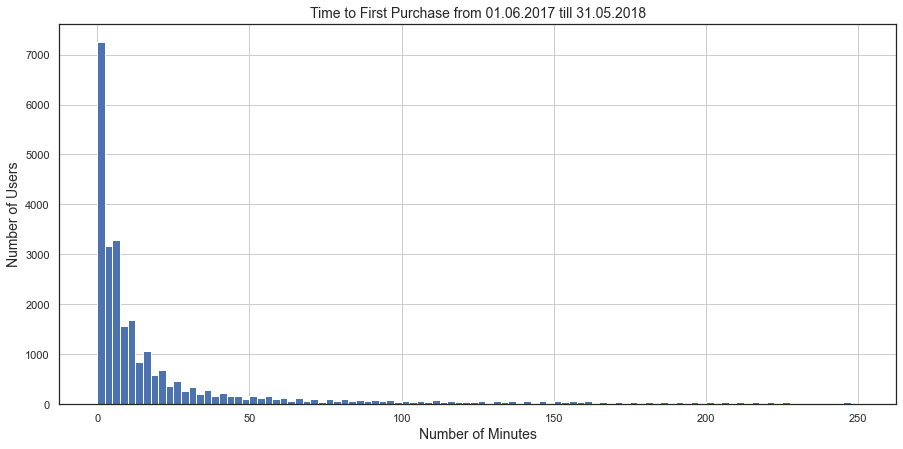

In [51]:
fig, ax = plt.subplots(figsize=(15,7))
plt.xlabel('Number of Minutes',fontsize=14)
plt.ylabel('Number of Users',fontsize=14)
plt.title('Time to First Purchase from 01.06.2017 till 31.05.2018',fontsize=14)
visit_to_order['time_to_order'].hist(bins=100, ax=ax, range=(0, 250))
plt.show()

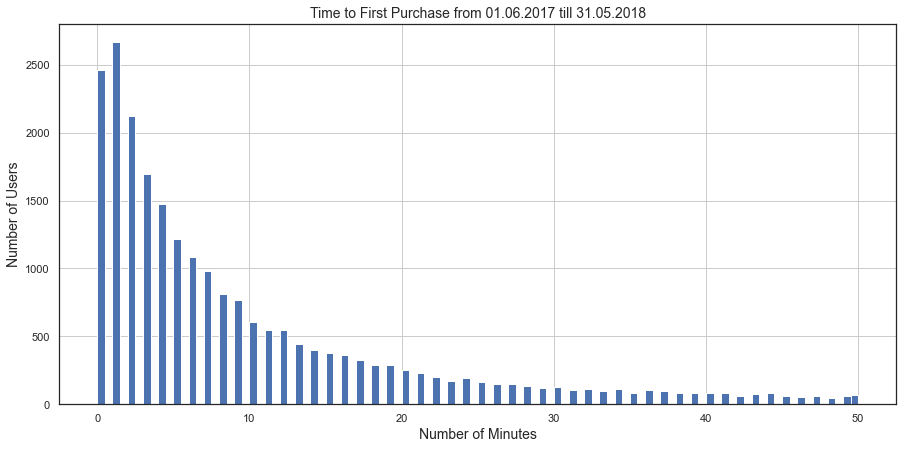

In [52]:
fig, ax = plt.subplots(figsize=(15,7))
plt.xlabel('Number of Minutes',fontsize=14)
plt.ylabel('Number of Users',fontsize=14)
plt.title('Time to First Purchase from 01.06.2017 till 31.05.2018',fontsize=14)
visit_to_order['time_to_order'].hist(bins=100, ax=ax, range=(0, 50))
plt.show()

In [53]:
a = visit_to_order['time_to_order'].mode()[0]
print('Average Time to First Purchase (in min):', a)

Average Time to First Purchase (in min): 1.0


The average user spends 1 minute on the website before making a purchase. (The distribution of time to purchase is similar to Pearson's distribution. When the distribution is close to normal or normal, you can look at the mean or median. Ours is not one of those, so we calculated the mode.)

50% of users spend on the wesite from 0 to 16 minutes before making a purchase.

25% of users spend on the website from 0 to 4 minutes only!

## 4.2.2. Orders per user in 6 months

In [54]:
orders['first_month'] = orders['first_order_date_time'].astype('datetime64[M]')

In [55]:
cohort_sizes = (
    orders.groupby('first_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_month', 'n_buyers']

cohorts = (
    orders.groupby(['first_month', 'month'])
    .agg({'revenue': 'count'})
    .reset_index()
)

report = pd.merge(cohort_sizes, cohorts, on='first_month')

report['age'] = (report['month'] - report['first_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

report['av_exp'] = report['revenue'] / report['n_buyers']

report['first_month'] = pd.to_datetime(report['first_month']).dt.to_period('M')

output = report.pivot_table(
    index='first_month', columns='age', values='av_exp', aggfunc='mean'
).round(2)

output_cum = output.cumsum(axis=1).round(2) 

print('The average number of orders for 1 user for 6 months is', round(output_cum[5].mean(),3))

The average number of orders for 1 user for 6 months is 1.429


## 4.2.3. Average Revenue per Purchase

In [56]:
print('Average revenue per purchase is', round((orders['revenue'].sum()/orders['revenue'].count()),2), 'с.u.')

Average revenue per purchase is 5.0 с.u.


In [57]:
orders_month = orders.groupby(['month']).agg({'revenue': ['count', 'sum']}).reset_index()
orders_month.columns = orders_month.columns.droplevel(0)
orders_month.columns = ['month', 'count', 'sum']
orders_month['rev_per_purchase'] = orders_month['sum'] / orders_month ['count']
orders_month=orders_month.drop(columns=['count', 'sum'])
print(orders_month)

        month  rev_per_purchase
0  2017-06-01          4.061832
1  2017-07-01          5.308836
2  2017-08-01          4.857892
3  2017-09-01          5.422852
4  2017-10-01          4.930016
5  2017-11-01          4.796231
6  2017-12-01          5.863455
7  2018-01-01          4.112927
8  2018-02-01          4.841011
9  2018-03-01          5.414946
10 2018-04-01          5.163265
11 2018-05-01          4.773476
12 2018-06-01          3.420000


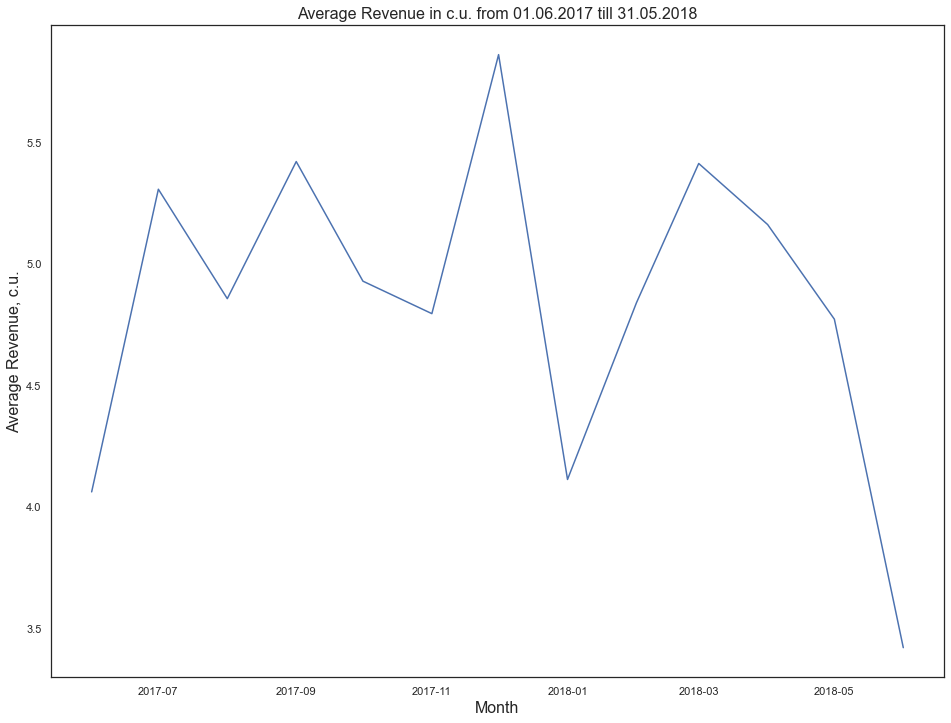

In [58]:
plt.figure(figsize=(16, 12))
sns.lineplot(x='month', y='rev_per_purchase', data=orders_month, palette="prism", markers=True)
plt.ylabel('Average Revenue, с.u.',fontsize=16)
plt.xlabel('Month',fontsize=16)
plt.title('Average Revenue in с.u. from 01.06.2017 till 31.05.2018',fontsize=16)
plt.show()

The average revenue per purchase for the entire observation period is 5 c.u., it fluctuates between 3.5 and 6 c.u.

Peak periods are in July **5.3 c.u.** (holidays and vacations), September **5.4 c.u.** (preparation for the new academic year and the new working season), December **5.86 c.u.** (New Year's gifts), March **5.41 c.u.** (March 8th). Pick periods are followed by the periods of decline (between the holidays).

## 4.2.4. Cohort Analysis - LTV

- Calculate the average LTV by cohort for 6 months;
- Include in the calculation cohorts that have "lived" for at least 6 months. 
- The website margin is 100%.

In [59]:
cohort_sizes = (
    orders.groupby('first_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_month', 'n_buyers']

cohorts = (
    orders.groupby(['first_month', 'month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)

report = pd.merge(cohort_sizes, cohorts, on='first_month')

margin_rate = 1

report['gp'] = report['revenue'] * margin_rate
report['age'] = (
    report['month'] - report['first_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

report['ltv'] = report['gp'] / report['n_buyers']

report['first_month'] = pd.to_datetime(report['first_month']).dt.to_period('M')

output = report.pivot_table(
    index='first_month', columns='age', values='ltv', aggfunc='mean'
).round(2)

output.fillna('') 

# Let's delete the last cohort, it has only 2 hours
output.drop(output.tail(1).index,inplace=True)

output_cum = output.cumsum(axis=1).round(2) 

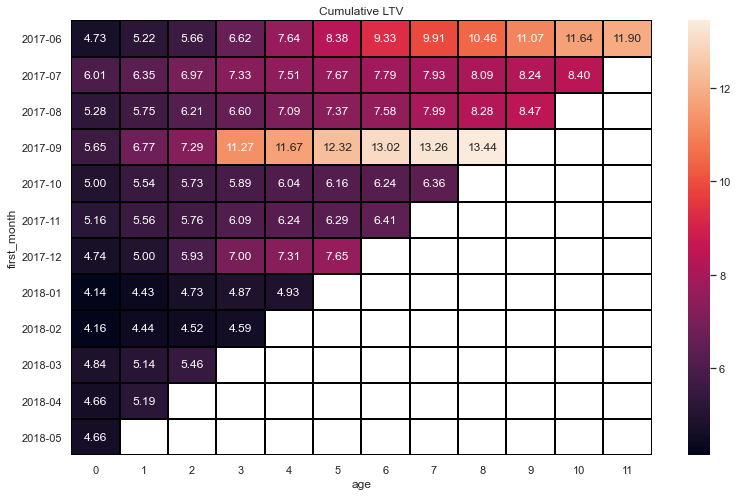

In [60]:
plt.figure(figsize=(13, 8))
plt.title('Cumulative LTV')
sns.heatmap(output_cum, annot=True, fmt='.2f', linewidths=1, linecolor='black')
plt.show()

In [61]:
print(output_cum.mean(axis=0)[5].round(2))

7.98


LTV is growing every month in all cohorts, but at different rates.

The most promising are cohorts 1 and 4.

The first one reached a cumulative LTV of 11.9 c.e. for 12 months of observation.

The fourth one reached 11.27 c.u. in 4 months.

The cumulative LTV of the rest of the cohorts reaches only 4-8 c.u. for the entire observation period.

The average cumulative LTV for among all cohorts for the period of the first 6 months is 7.98 c.u.

# 4.3 Marketing Metrics

**Calculate how marketing metrics differ across advertising sources. The same user could access the site from several ad sources, so it is important to determine the "main" source for each and take this into account in the calculations. For example, the first transition source can become the main one.**

## 4.3.1.1 Total Marketing Costs

In [62]:
print('Total Marketing Costs:', costs['costs'].sum(), 'c.u.')

Total Marketing Costs: 329131.62 c.u.


## 4.3.1.2 Costs by Ad Source

In [63]:
costs_source = costs.groupby('source').agg({'costs':'sum'}).reset_index()
costs_source = costs_source.sort_values(by = 'costs', ascending=False)
costs_source['% from total'] = round((costs_source['costs']/(costs['costs'].sum()))*100,0)
print(costs_source)

     source      costs  % from total
3   source3  141321.63          43.0
4   source4   61073.60          19.0
5   source5   51757.10          16.0
2   source2   42806.04          13.0
0   source1   20833.27           6.0
1  source10    5822.49           2.0
6   source9    5517.49           2.0


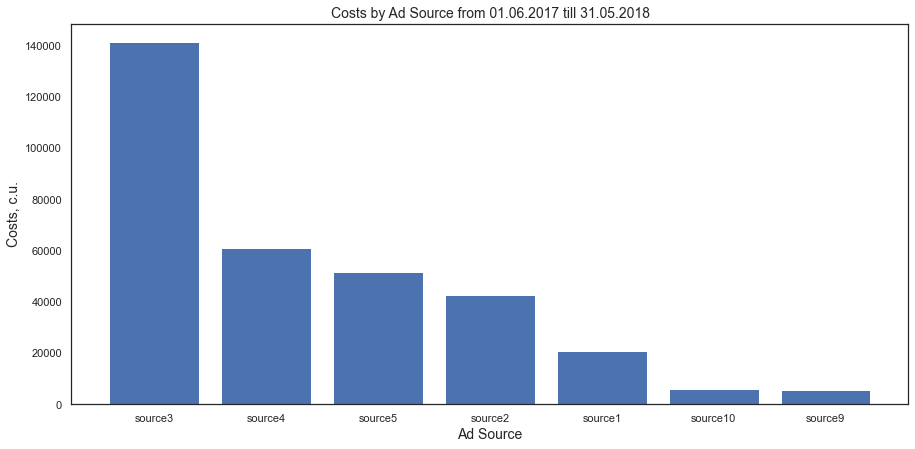

In [64]:
fig, ax = plt.subplots(figsize=(15,7))
plt.xlabel('Ad Source',fontsize=14)
plt.ylabel('Costs, c.u.',fontsize=14)
plt.title('Costs by Ad Source from 01.06.2017 till 31.05.2018',fontsize=14)

y_pos = np.arange(len(costs_source['costs']))
bars = plt.bar(y_pos, costs_source['costs'])
plt.xticks(y_pos, costs_source['source'])
plt.show()

43% of the advertising budget goes to source 3<br/>
19% for source 4<br/>
16% for source 5<br/>
13% for source 2<br/>
6% for source 10<br/>
and 2% each for sources 9 and 10

## 4.3.1.3 Ad Costs throughout Time

In [65]:
costs['month'] = costs['date'].astype('datetime64[M]')
costs_source_time = costs.groupby(['source', 'month']).agg({'costs':'sum'}).reset_index()
costs_source_time=costs_source_time.sort_values(by='costs')
print(costs_source_time)

      source      month     costs
14  source10 2017-08-01    232.57
74   source9 2017-08-01    248.93
72   source9 2017-06-01    285.22
73   source9 2017-07-01    302.54
12  source10 2017-06-01    314.22
..       ...        ...       ...
44   source3 2018-02-01  14228.56
43   source3 2018-01-01  14808.78
40   source3 2017-10-01  15737.24
42   source3 2017-12-01  16219.52
41   source3 2017-11-01  17025.34

[84 rows x 3 columns]


In [66]:
costs_source_per_month = costs_source_time.groupby(['source']).agg({'costs':'sum'}).reset_index()
costs_source_per_month['costs'] = round(costs_source_per_month['costs'] / 12,2)
print('Average Monthly Cost per Source, c.u.')
print(costs_source_per_month)

Average Monthly Cost per Source, c.u.
     source     costs
0   source1   1736.11
1  source10    485.21
2   source2   3567.17
3   source3  11776.80
4   source4   5089.47
5   source5   4313.09
6   source9    459.79


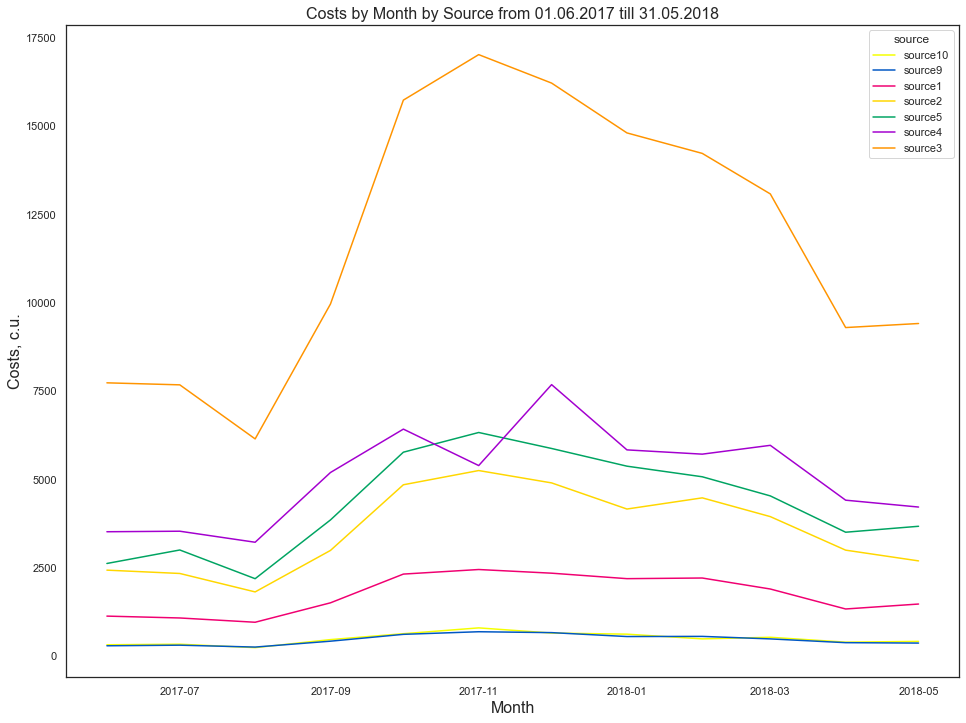

In [67]:
plt.figure(figsize=(16, 12))
sns.lineplot(x='month', y='costs', hue='source', data=costs_source_time, palette="prism", markers=True)
plt.xlabel('Month',fontsize=16)
plt.ylabel('Costs, c.u.',fontsize=16)
plt.title('Costs by Month by Source from 01.06.2017 till 31.05.2018',fontsize=16)
plt.show()

Ad costs across all sources (except 4, 9, and 10) go up from September 2017 to November 2017 and fall from November until the end of the observation period.

The costs for source 4 rise until October, fall in November, rise again in December, and fall until the end of the observation period.

Expenses for all sources except 3,9 and 10 reach from 2 to 7.5 thousand c.u. per month.

Spending on 9 and 10 sources fluctuate around 400-500 c.u. per month.

Spending on 3 (the most expensive) source has the highest amplitude, starts growing from 7.5 thousand USD in June and reaches 17 thousand USD per month in November.

## 4.3.2. Customer Acquisition Cost (CAC) per Ad Source

In [68]:
print('The number of Uniqie Users: ', orders['uid'].nunique())
print('Total Ad Costs in c.u.: ', costs['costs'].sum())
print('CAC per User in c.u.: ', round(costs['costs'].sum()/orders['uid'].nunique(),2))

The number of Uniqie Users:  36509
Total Ad Costs in c.u.:  329131.62
CAC per User in c.u.:  9.02


In [69]:
costs_agg = costs.groupby('month').agg({'costs':'sum'}).reset_index()
orders_agg = orders.merge(visits, on=['uid', 'month'], how='inner')
orders_agg = orders_agg.groupby('month').agg({'uid':'nunique'}).reset_index()
cac_agg = orders_agg.merge(costs_agg, on='month', how='inner')
cac_agg['cac'] = cac_agg['costs'] / cac_agg['uid']
print(cac_agg)

        month   uid     costs        cac
0  2017-06-01  2022  18015.00   8.909496
1  2017-07-01  1928  18240.59   9.460887
2  2017-08-01  1393  14790.54  10.617760
3  2017-09-01  2612  24368.91   9.329598
4  2017-10-01  4464  36322.88   8.136846
5  2017-11-01  4285  37907.88   8.846646
6  2017-12-01  4596  38315.35   8.336673
7  2018-01-01  3550  33518.52   9.441837
8  2018-02-01  3856  32723.03   8.486263
9  2018-03-01  3743  30415.27   8.125907
10 2018-04-01  2453  22289.38   9.086580
11 2018-05-01  3196  22224.27   6.953777


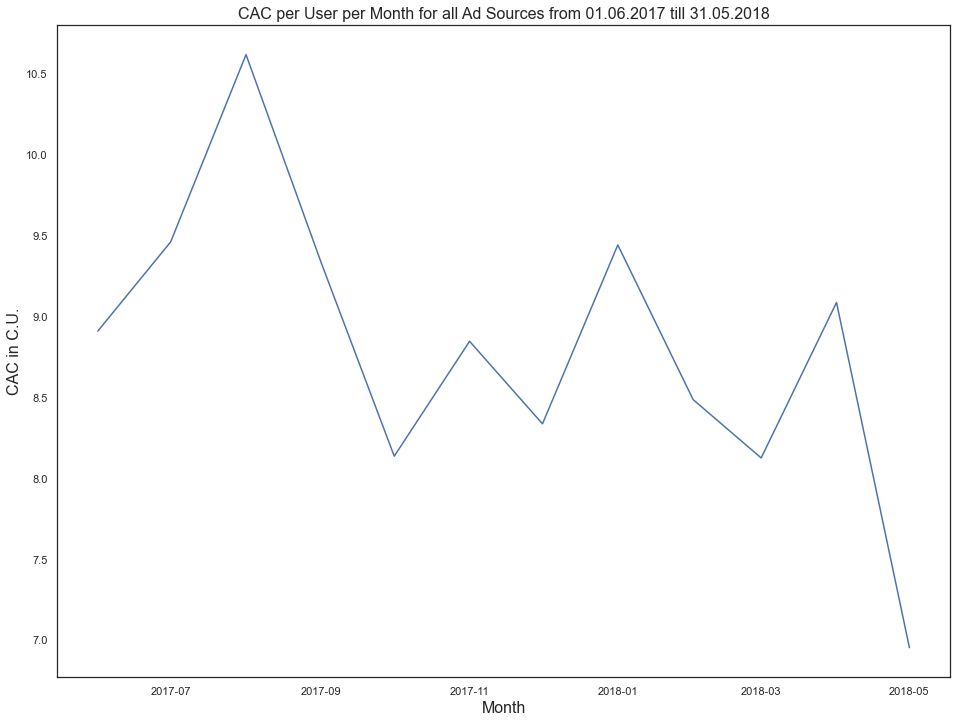

In [70]:
plt.figure(figsize=(16, 12))
sns.lineplot(x='month', y='cac', data=cac_agg)
plt.xlabel('Month',fontsize=16)
plt.ylabel('CAC in C.U.',fontsize=16)
plt.title('CAC per User per Month for all Ad Sources from 01.06.2017 till 31.05.2018',fontsize=16)
plt.show()

User Acquisition Cost (CAC) falls during the holiday periods (September, December, March when users are willing to spend more) and peaks in between (transition period between the holidays).

CAC for all sources ranges from 7 to 11 c.u. depending on the month.

In [71]:
costs_source_time = costs.groupby(['source', 'month']).agg({'costs':'sum'}).reset_index()
orders_with_source = orders.merge(visits, on=['uid', 'month'], how='inner')
orders_source_time = orders_with_source.groupby(['source', 'month']).agg({'uid':'nunique'}).reset_index()
cac = orders_source_time.merge(costs_source_time, on=['source', 'month'], how='inner')
cac['cac'] = cac['costs'] / cac['uid']
print(cac)

     source      month  uid    costs       cac
0   source1 2017-06-01  325  1125.61  3.463415
1   source1 2017-07-01  338  1072.88  3.174201
2   source1 2017-08-01  233   951.81  4.085021
3   source1 2017-09-01  456  1502.01  3.293882
4   source1 2017-10-01  723  2315.75  3.202974
..      ...        ...  ...      ...       ...
79  source9 2018-01-01  142   547.16  3.853239
80  source9 2018-02-01  127   551.50  4.342520
81  source9 2018-03-01  315   480.29  1.524730
82  source9 2018-04-01   64   373.49  5.835781
83  source9 2018-05-01   86   362.17  4.211279

[84 rows x 5 columns]


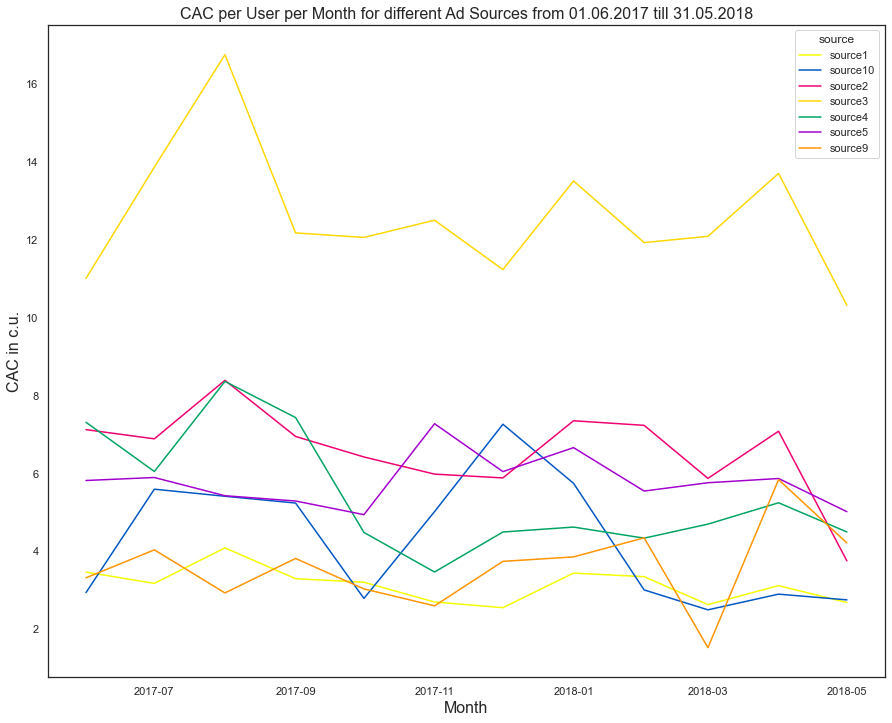

In [72]:
plt.figure(figsize=(15, 12))
sns.lineplot(x='month', y='cac', hue='source', data=cac, palette="prism", markers=True)
plt.xlabel('Month',fontsize=16)
plt.ylabel('CAC in c.u.',fontsize=16)
plt.title('CAC per User per Month for different Ad Sources from 01.06.2017 till 31.05.2018',fontsize=16)
plt.show()

User Acquisition Cost (CAC) falls during the holiday periods (September, December, March when users are willing to spend more) and peaks in between (transition period between the holidays).

CAC for all sources ranges from 7 to 11 c.u. depending on the month.

Source number 3 is the most expensive. It accounts for 43% of all expenses, while its CAC ranges from 12 to 17 c.u. depending on the month.

## 4.3.3. Cohort Analysis: ROMI per Ad Source

ROMI = LTV / CAC

We'll need costs and orders (with the ad source per each user) to calculate ROMI

In [73]:
visits_source = visits[['start_ts', 'uid', 'first_session_date_time', 'source']]
visits_source = visits_source.loc[visits_source['first_session_date_time'] == visits_source['start_ts']]
visits_source.drop(columns=['first_session_date_time', 'start_ts'])
visits_source=visits_source.dropna(subset=['source'])
orders = orders.merge(visits_source, on='uid', how='inner')
print(orders)

                   buy_ts  revenue                   uid      month  \
0     2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01   
1     2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01   
2     2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01   
3     2017-06-01 00:29:00     0.55  16109239769442553005 2017-06-01   
4     2017-06-01 07:58:00     0.37  14200605875248379450 2017-06-01   
...                   ...      ...                   ...        ...   
50358 2018-05-31 23:50:00     4.64  12296626599487328624 2018-05-01   
50359 2018-05-31 23:50:00     5.80  11369640365507475976 2018-05-01   
50360 2018-05-31 23:54:00     0.30   1786462140797698849 2018-05-01   
50361 2018-05-31 23:56:00     3.67   3993697860786194247 2018-05-01   
50362 2018-06-01 00:02:00     3.42     83872787173869366 2018-06-01   

            week       date first_order_date_time first_month  \
0     2017-06-01 2017-06-01   2017-06-01 00:10:00  2017-06-01   
1     2017-06-01 

Let's convert source back into integer to work with a loop in cohort analysis

In [74]:
costs.loc[(costs['source'] == 'source1'), 'source'] = 1
costs.loc[(costs['source'] == 'source2'), 'source'] = 2
costs.loc[(costs['source'] == 'source3'), 'source'] = 3
costs.loc[(costs['source'] == 'source4'), 'source'] = 4
costs.loc[(costs['source'] == 'source5'), 'source'] = 5
costs.loc[(costs['source'] == 'source9'), 'source'] = 9
costs.loc[(costs['source'] == 'source10'), 'source'] = 10

costs['source'] = costs['source'].astype(int)

In [75]:
orders.loc[(orders['source'] == 'source1'), 'source'] = 1
orders.loc[(orders['source'] == 'source2'), 'source'] = 2
orders.loc[(orders['source'] == 'source3'), 'source'] = 3
orders.loc[(orders['source'] == 'source4'), 'source'] = 4
orders.loc[(orders['source'] == 'source5'), 'source'] = 5
orders.loc[(orders['source'] == 'source9'), 'source'] = 9
orders.loc[(orders['source'] == 'source10'), 'source'] = 10

orders['source'] = orders['source'].astype(int)

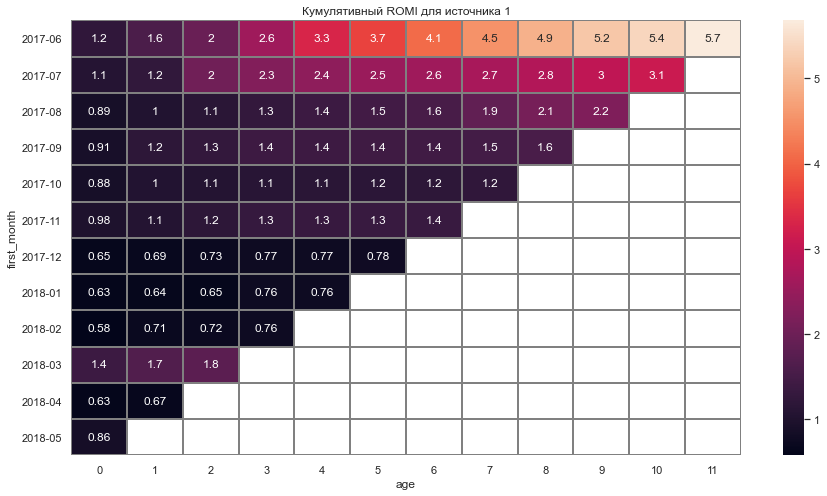

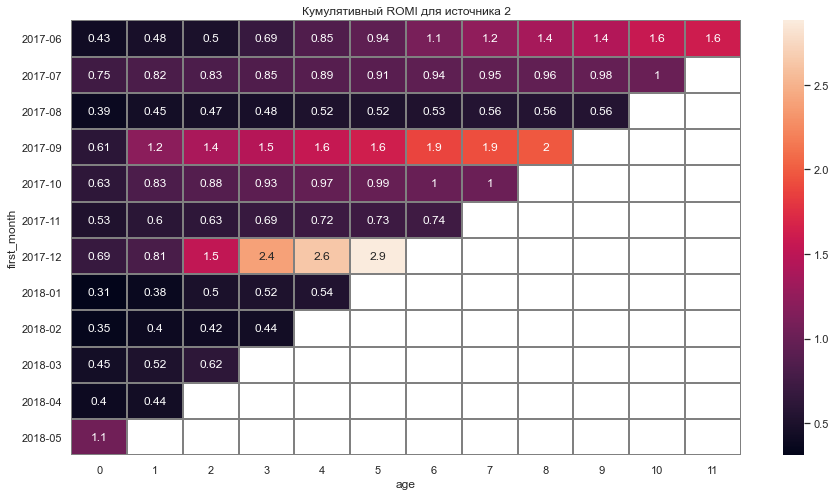

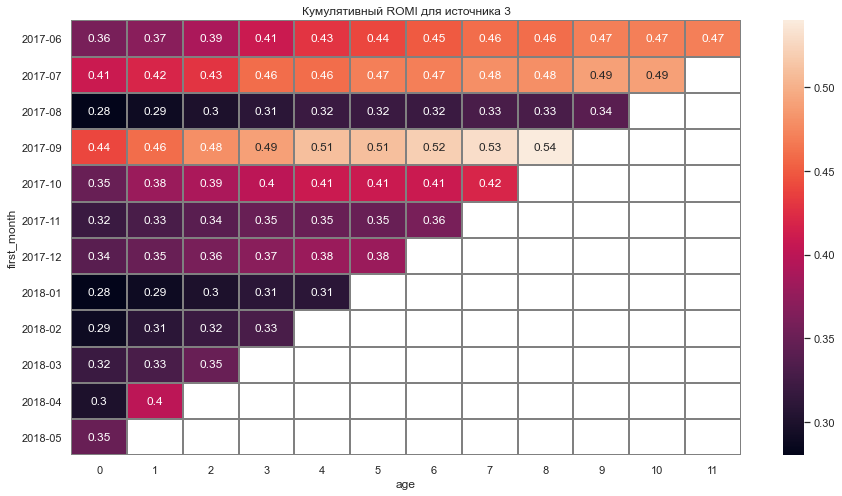

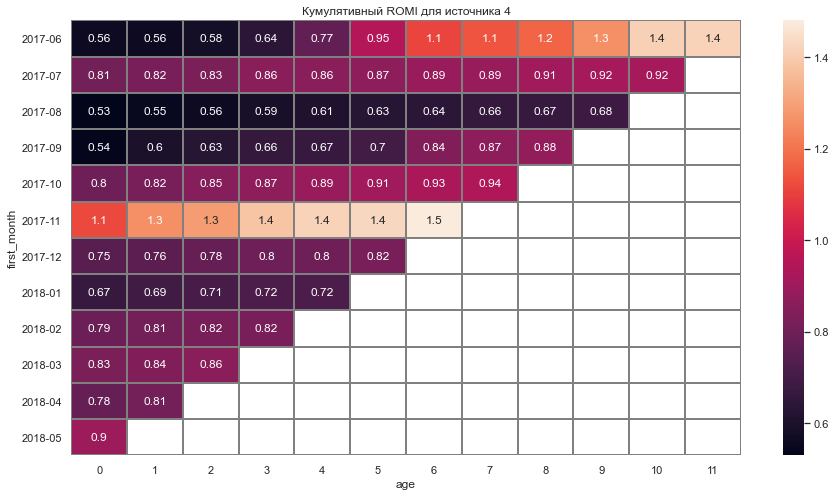

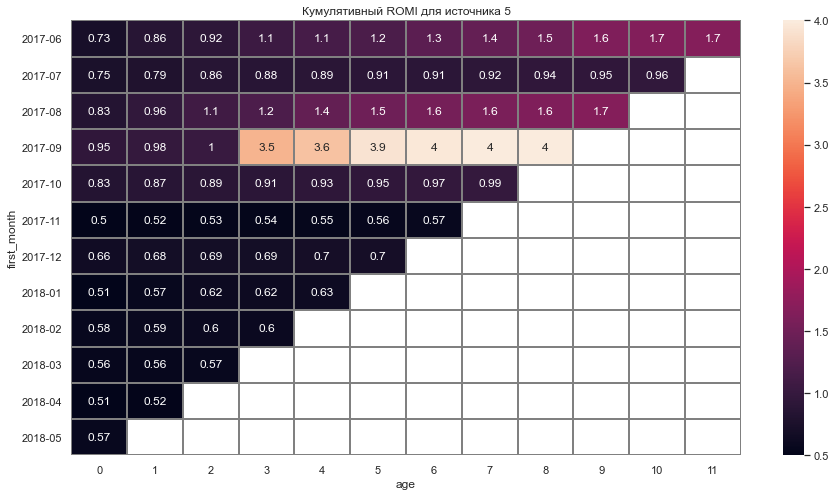

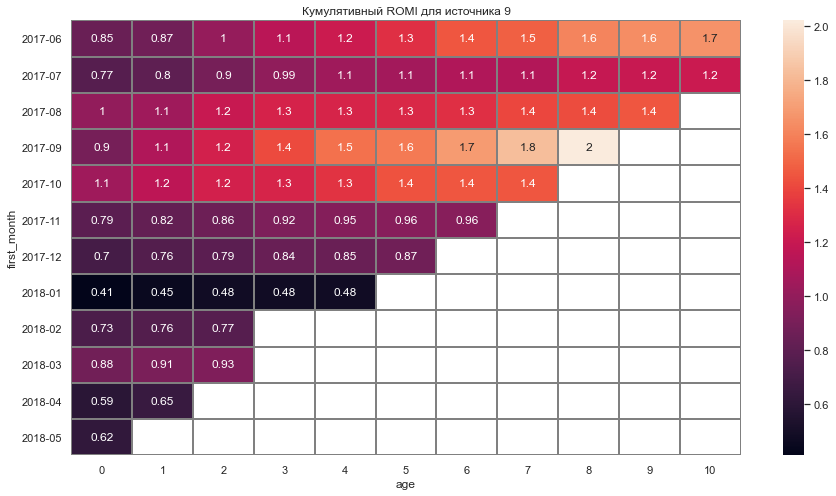

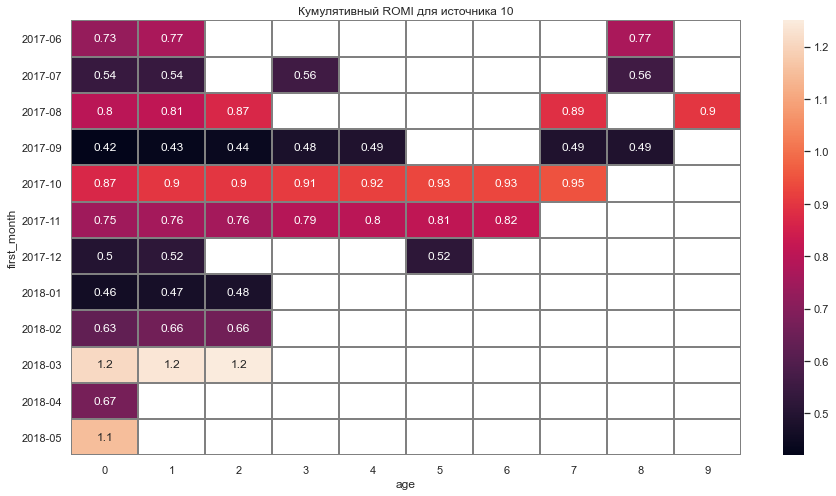

In [76]:
source_list = orders['source'].unique()
source_list = np.sort(source_list)
 
#For each ad source:
for source in source_list:
    margin_rate = 1.0
    source = int(source)
    orders_m = orders.loc[orders['source'] == source]
    costs_m = costs.loc[costs['source'] == source]
 
    #Calculating the number of customers for each month:
    cohort_sizes = (
    orders_m.groupby('first_month')
    .agg({'uid': 'nunique'})
    .reset_index()
    )
    cohort_sizes.columns = ['first_month', 'n_buyers']
 
    #Grouping the table of orders by the month of the first purchase and revenue:
    cohorts = (
    orders_m.groupby(['first_month', 'month'])
    .agg({'revenue': 'sum'})
    .reset_index()
    ) 
 
    #Let's add the data on how many customers made a purchase for the first time in each month:
    report = pd.merge(cohort_sizes, cohorts, on='first_month')
 
    #Calculating revenuew and the age of cohorts:
    report['gp'] = report['revenue'] * margin_rate
    report['age'] = (report['month'] - report['first_month']) / np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')
 
    #Calculating LTV:
    report['ltv'] = report['gp'] / report['n_buyers']
 
    # Calculating monthly costs:
    monthly_costs = costs_m.groupby('month').sum()
 
    #Calculating CAC:
    report_new = pd.merge(report, monthly_costs, left_on='first_month', right_on='month')
    report_new['cac'] = report_new['costs'] / report_new['n_buyers']
 
    #Calculating ROMI:
    report_new['romi'] = report_new['ltv'] / report_new['cac']
    report_new['first_month'] = pd.to_datetime(report_new['first_month']).dt.to_period('M')
    output = report_new.pivot_table(index='first_month', columns='age', values='romi', aggfunc='mean')
    output_cum = output.cumsum(axis=1).round(2)
    
    #Building ROMI graph for this source:
    a = str(source)
    sns.set(style='white')   
    plt.figure(figsize=(15, 8))
    plt.title('Кумулятивный ROMI для источника ' + a)
    sns.heatmap(output_cum, annot=True, linewidths=1, linecolor='gray');
    
    #Emptying the dataframes for the next source
    orders_m = orders_m.iloc[0:0]
    costs_m = costs_m.iloc[0:0]

Source 1 paid off in 2 months in all cohorts

Source 2 paid off only in cohorts 1 (in 8 months), 4 (in 2 months), 5 (in 6 months), 7 (in 2 months)

Source 3 did not pay off in any cohort over the entire observation period

Source 4 paid off only in cohorts 1 (in 10 months), 6 (in a month)

Source 5 paid if on average for all cohorts pays off in 6 months of observations

Source 9 paid off in 6 months in all cohorts

Source 10 paid off only in cohorts 10 and 12 (in a month)

<h1 style="color:green; margin-bottom:15px;font-size:30px">5. Conclusions and Recommendations</h1>

## 5.1. Product Metrics: DAU, WAU, MAU

**DAU**

<ul>
<li>Average number of unique users per day - 907</li>
<li>DAU Maximum (3319 users) was reached on 2017-11-24, Black Friday 2017</li>
<li>DAU Minimum was reached on 2018-03-30 and 2018-03-31 (1 and 131 users), most likely due to site outages</li>
<li>DAU peaks mid-week and drops over the weekend</li>
</ul>

**WAU**
<ul>
<li>Average number of unique users per week - 5724</li>
<li>WAU Maximum (10716 users) was reached on Black Friday 2017 week</li>
<li>WAU Minimum (1997 users) was reached on site outages week</li>
</ul>

**MAU** 
<ul>
<li>Average number of unique users per month - 23228</li>
<li>MAU Maximum (32797 users) was reached in November 2017</li>
<li>MAU Minimum (11631 users) was reached in August 2017</li>
<li>MAU fluctuates around 10-15k users from June to August 2017, starts to grow from August 2017 (11631 users), peaks in November 2017 (32797) and goes down till the end of observations</li>
</ul>

The two-day site outage affected DAU and WAU, and Black Friday set the maximum for DAU, WAU, MAU for the entire observation period


## 5.2. Product Metrics: ASR

The average session duration is 1 minute. 

50% of users spend on the website 0-5 minutes.

## 5.3. Product Metrics: Retention Rate

The user retention rate is quite low for all cohorts and decreases every month in each cohort.

The average retention rate on the 2nd month across all cohorts is 6.5%.

The highest retention rate was reached in the first cohort - 4.5% after 11 months of follow-up.

The rest of the cohorts (except for the last one) achieve 1.9-2.7% retention by the end of the follow-up period.

## 5.4. Ecommerce Metrics

The average user spends 1 minute on the website before making a purchase.

50% of users spend on the wesite from 0 to 16 minutes before making a purchase.

25% of users spend on the website from 0 to 4 minutes only!

The average customer makes one purchase in the first month and 1.43 in 6 months.

The average revenue per purchase for the entire observation period is 5 c.u. (3.5-6 c.u.)

Peak periods are in July 5.3 c.u. (holidays and vacations), September 5.4 c.u. (preparation for the new academic year and the new working season), December 5.86 c.u. (New Year's gifts), March 5.41 c.u. (March 8th). Pick periods are followed by the periods of decline (between the holidays).

**LTV**

LTV is growing every month in all cohorts, but at different rates.

The most promising are cohorts 1 and 4.

The first one reached a cumulative LTV of 11.9 c.e. for 12 months of observation.

The fourth one reached 11.27 c.u. in 4 months.

The cumulative LTV of the rest of the cohorts reaches only 4-8 c.u. for the entire observation period.

The average cumulative LTV for among all cohorts for the period of the first 6 months is 7.98 c.u.

## 5.5. Marketing Metrics: CAC by Ad Source

For the entire observation period, about 330 thousand c.u. was spent on advertising. Among them:

In [77]:
print(costs_source[['source','% from total']])

     source  % from total
3   source3          43.0
4   source4          19.0
5   source5          16.0
2   source2          13.0
0   source1           6.0
1  source10           2.0
6   source9           2.0


User Acquisition Cost (CAC) falls during the holiday periods (September, December, March when users are willing to spend more) and peaks in between (transition period between the holidays).

CAC for all sources ranges from 7 to 11 c.u. depending on the month.

Source number 3 is the most expensive. It accounts for 43% of all expenses, while its CAC ranges from 12 to 17 c.u. depending on the month.

## 5.6. Marketing Metrics: ROMI by Ad Source

Source 1 paid off in 2 months in all cohorts

Source 2 paid off only in cohorts 1 (in 8 months), 4 (in 2 months), 5 (in 6 months), 7 (in 2 months)

Source 3 did not pay off in any cohort over the entire observation period

Source 4 paid off only in cohorts 1 (in 10 months), 6 (in a month)

Source 5 paid if on average for all cohorts pays off in 6 months of observations

Source 9 paid off in 6 months in all cohorts

Source 10 paid off only in cohorts 10 and 12 (in a month)

<h1 style="color:green; margin-bottom:15px;font-size:30px">5.7 Recommendations</h1>

I recommend reallocating ad spend based on the performance of each source and the ROMI of specific cohorts.

**50% of budget:**
- source 1 (70% among the cohorts that have already paid off, 30% among the remaining ones)

**20% of budget:**
- source 5 (70% among the cohorts that have already paid off, 30% among the remaining ones)

**20% of budget:**
- source 9 (70% among the cohorts that have already paid off, 30% among the remaining ones)

**5% of budget:**
- sources 2, 4, 10 - only among the cohorts that already paid off

**5% of budget:**
- testing new advertising sources

**Source 3 must be completely abandoned**